<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/13-AI4Sound/EVA4P2S13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  numpy keras librosa matplotlib

In [ ]:
import os 
os.listdir('./')

['.config', 'blues.00000.wav', 'sample_data']

In [ ]:
import librosa
import numpy as np
import librosa.display
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!apt-get install -y -qq ffmpeg

In [ ]:
y, sr = librosa.load(librosa.util.example_audio_file(), duration=10)

In [ ]:
print(y,y.shape)

[ 0.          0.          0.         ... -0.07654281 -0.0804726
 -0.09472633] (220500,)


In [ ]:
sr

22050

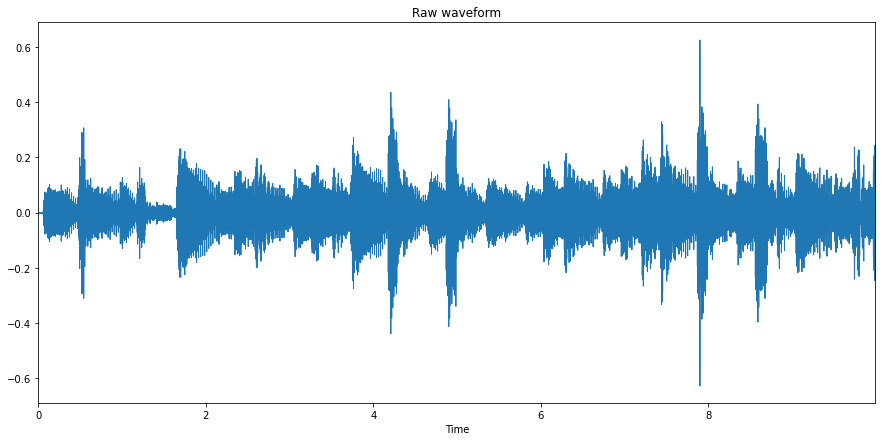

In [ ]:
plt.figure(figsize=(15,7))
librosa.display.waveplot(y,sr=sr)
plt.title('Raw waveform')
plt.show()

In [ ]:
import IPython.display as ipd

In [ ]:
ipd.Audio(y,rate=sr)

In [ ]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
mfcc

array([[-585.74258221, -536.98026502, -420.33729707, ..., -312.36725669,
        -294.1104376 , -296.64193221],
       [   0.        ,   60.42567623,  147.08731492, ...,  100.49875748,
          98.6326375 ,  129.67881767],
       [   0.        ,   41.15048816,   35.22410725, ...,   67.2011451 ,
          74.83373746,   78.34393586],
       ...,
       [   0.        ,   -9.40651646,   -5.60343754, ...,    6.0100009 ,
           5.52348393,    2.21866423],
       [   0.        ,   -7.86510647,   -5.9375782 , ...,    3.39014456,
           4.68482683,    8.28399921],
       [   0.        ,   -4.03834951,   -4.45187158, ...,   -5.21105313,
          -6.87013638,   -5.5506121 ]])

In [ ]:
mfcc.shape

(20, 431)

In [ ]:
mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=13,
                             n_fft=int(0.02*sr),hop_length=int(0.01*sr))

In [ ]:
mfcc.shape

(13, 1003)

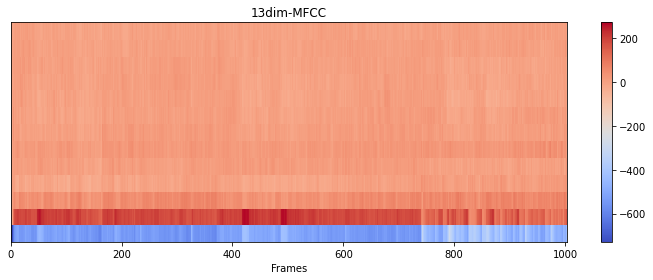

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='frames')
plt.colorbar()
plt.title('13dim-MFCC')
plt.tight_layout()

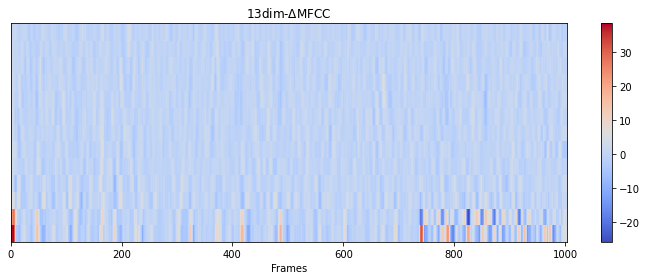

In [ ]:
plt.figure(figsize=(10, 4))
delta=librosa.feature.delta(mfcc)
librosa.display.specshow(delta, x_axis='frames')
plt.colorbar()
plt.title('13dim-$\Delta$MFCC')
plt.tight_layout()

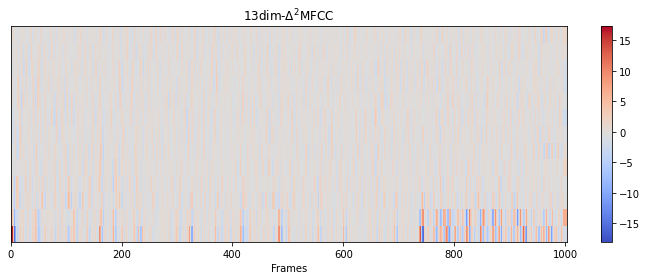

In [ ]:
plt.figure(figsize=(10, 4))
delta2=librosa.feature.delta(mfcc,order=2)
librosa.display.specshow(delta2, x_axis='frames')
plt.colorbar()
plt.title('13dim-$\Delta^2$MFCC')
plt.tight_layout()

In [ ]:
con_mfcc=np.concatenate((mfcc,delta,delta2),axis=0)
con_mfcc.shape


(39, 1003)

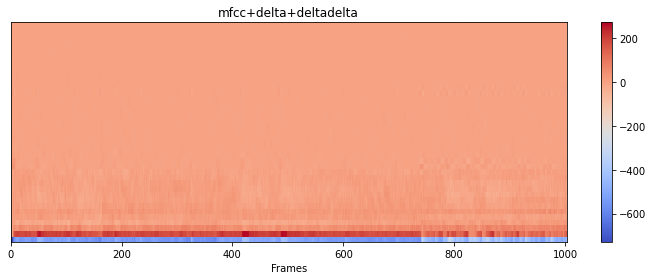

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(con_mfcc, x_axis='frames')
plt.colorbar()
plt.title('mfcc+delta+deltadelta')
plt.tight_layout()

# Simple Speech to Text

[Ref](https://colab.research.google.com/drive/1qFt8qxKtM05hRuRxsA1Lq4JtP7tstcgc?pli=1&authuser=1#scrollTo=HfDVGhsCYWKx)

# Part 1: Working with audio data

The dataset we are using is Google's Speech Dataset (https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html).

It is composed of **"65,000 one-second long utterances of 30 short words, by thousands of different people"**.

Let's download the dataset:


In [ ]:
!rm -rf ./*
!wget -O speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!tar xzf speech_commands_v0.01.tar.gz 
!ls

--2020-11-06 09:10:46--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.28.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.28.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  73.5MB/s    in 23s     

2020-11-06 09:11:10 (60.7 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

_background_noise_  go	     on				   testing_list.txt
bed		    happy    one			   three
bird		    house    README.md			   tree
cat		    left     right			   two
dog		    LICENSE  seven			   up
down		    marvin   sheila			   validation_list.txt
eight		    nine     six			   wow
five		    no	     speech_commands_v0.01.tar.gz  yes
four		    off      stop			   zero


In [ ]:
!pip install torchaudio

     |████████████████████████████████| 7.6MB 4.2MB/s 


In [ ]:
from IPython.display import Audio

## PyTorch things
import torch
import torchaudio
import torch.nn.functional as F

## Other libs
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm import tqdm_notebook
import torchsummary
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Let's print the different classes (words) that are part of this dataset.

We can see there are 30 different words.

In [ ]:
classes = os.listdir()
classes.remove("LICENSE")
classes.remove("README.md")
classes.remove("_background_noise_")
classes.remove("speech_commands_v0.01.tar.gz")
classes.remove("testing_list.txt")
classes.remove("validation_list.txt")
classes.remove(".config")
print(classes)
print("Number of classes", len(classes))

['right', 'on', 'sheila', 'bed', 'zero', 'seven', 'up', 'six', 'down', 'tree', 'one', 'stop', 'yes', 'five', 'nine', 'off', 'go', 'no', 'two', 'four', 'bird', 'three', 'happy', 'cat', 'marvin', 'dog', 'house', 'eight', 'left', 'wow']
Number of classes 30


## Listen to some samples

Using the **Audio(filename)** function from IPython notebook, you can listen to an audio file directly in Colab.

Try it on some samples!

In [ ]:
Audio("bed/1528225c_nohash_2.wav")

In [ ]:
Audio("cat/004ae714_nohash_0.wav")

## Displaying a waveform

Use **torchaudio.load** to load an audio file. Then, use matplotlib to display it.

HINT: you may have to transpose the waveform with **.t()** in order to display it

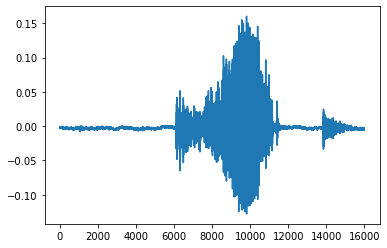

In [ ]:
waveform, sample_rate = torchaudio.load("cat/004ae714_nohash_0.wav", normalization=True)

plt.plot(waveform.t())

## Computing MFCC features

Extracting MFCC (**Mel Frequency Cepstral Coefficients**) features is a well known signal processing technique, especially used in **ASR** (Automatic Speech Recognition). These features are meant to represent the way humans perceive sound. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

*Torchaudio* has transforms (just like the ones in *torchvision*) that allow you to compute these features:

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally a

torch.Size([1, 12, 81])


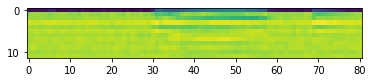

In [ ]:
mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)

Here, we are only keeping 12 MFCC features because it is enough for our purposes.

As you can see, we are getting a Tensor of shape [1, 12, 81], because we have one audio channel (mono) with 12 coefficients over 81 time windows.

## Creating a custom audio Dataset

You may have noticed that in this dataset, the test and validation datasets are given in testing_list.txt and validation_list.txt files. 

With that, we can infer a training list as well:

In [ ]:
## Read the test list
with open("testing_list.txt") as testing_f:
  testing_list = [x.strip() for x in testing_f.readlines()]

## Read the val list
with open("validation_list.txt") as val_f:
  validation_list = [x.strip() for x in val_f.readlines()]  

print("Number of testing samples", len(testing_list))
print("Number of validation samples", len(validation_list))

## Construct a train list
training_list = []
for c in classes:
  training_list += glob.glob(c + "/*")

training_list = list(filter(lambda x : not x in testing_list and not x in validation_list, training_list))
print("Number of training samples", len(training_list))

Number of testing samples 6835
Number of validation samples 6798
Number of training samples 51088


Now, we can create a custom SpeechDataset class that takes a file list in input.

In [ ]:
class SpeechDataset(torch.utils.data.Dataset):
  
  def __init__(self, classes, file_list):
    
    self.classes = classes
    
    # create a map from class name to integer
    self.class_to_int = dict(zip(classes, range(len(classes))))
    
    # store the file names
    self.samples = file_list
    
    # store our MFCC transform
    self.mfcc_transform = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)
    
  def __len__(self):
    return len(self.samples)
    
  def __getitem__(self,i):
    with torch.no_grad():
      # load a normalized waveform
      waveform,_ = torchaudio.load(self.samples[i], normalization=True)
      
      # if the waveform is too short (less than 1 second) we pad it with zeroes
      if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)
      
      # then, we apply the transform
      #mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0,1)
    
    # get the label from the file name
    label = self.samples[i].split("/")[0]
    
    # return the mfcc coefficient with the sample label
    return waveform.t(), self.class_to_int[label]

## Create instances of the SpeechDataset for the train and val sets

Create your Dataset objects for training.

In [ ]:
train_set = SpeechDataset(classes, training_list)
val_set =SpeechDataset(classes, validation_list)

print(train_set[5][0].shape)

torch.Size([16000, 1])


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


## Create Dataloaders for training and validation

Create DataLoaders with the Datasets you just created.

Do not forget to add shuffling to the training DataLoader.

Print a batch of data to make sure everything works.

In [ ]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=16)

print(next(iter(train_dl)))

[tensor([[[ 1.2207e-04],
         [ 1.0071e-03],
         [ 1.3123e-03],
         ...,
         [ 2.1362e-04],
         [-6.1035e-05],
         [-5.1880e-04]],

        [[ 5.2795e-03],
         [ 5.2490e-03],
         [ 5.1270e-03],
         ...,
         [ 6.6833e-03],
         [ 6.8359e-03],
         [ 6.3477e-03]],

        [[-3.0518e-05],
         [ 1.8311e-04],
         [ 1.2207e-04],
         ...,
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00]],

        ...,

        [[ 1.8311e-04],
         [ 1.8311e-04],
         [ 2.4414e-04],
         ...,
         [ 3.9673e-04],
         [ 1.5259e-04],
         [ 2.1362e-04]],

        [[ 6.1035e-05],
         [ 3.0518e-05],
         [-6.1035e-05],
         ...,
         [-9.1553e-05],
         [-6.1035e-05],
         [-1.5259e-04]],

        [[ 6.1035e-05],
         [ 1.2207e-04],
         [ 2.4414e-04],
         ...,
         [-9.1553e-05],
         [-1.2207e-04],
         [ 3.0518e-05]]]), tensor([16,  4, 17, 10, 

# Part 2: Implementing a simple Recurrent Neural Network

For our network, we are going to use an **RNN module** from torch.nn (which can have multiple layers, or cells).

This module has an **input size**, which in our case will be equal to **the number of MFCC features (12)**. The input size is the number of dimensions of **x** in the image below.

## Implement the network

In [ ]:
class SpeechRNN(torch.nn.Module):
  
  def __init__(self):
    super(SpeechRNN, self).__init__()
    
    self.lstm = torch.nn.GRU(input_size = 1, 
                              hidden_size= 256, 
                              num_layers = 2, 
                              batch_first=True)
    
    self.out_layer = torch.nn.Linear(256, 30)
    
    self.softmax = torch.nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    
    out, _ = self.lstm(x)
    
    x = self.out_layer(out[:,-1,:])
    
    return self.softmax(x)

Use this code to check that your implementation is working.

In [ ]:
net = SpeechRNN().cuda()
batch = next(iter(train_dl))[0]
print(batch.shape)
y = net(batch.cuda())

print(y.shape)

torch.Size([16, 16000, 1])
torch.Size([16, 30])


# Part 3: Training the network

As usual, we need to define a loss and an optimizer. Since we have a categorical classification problem, we use cross-entropy (negative log likelihood).

We can use the Adam optimizer, feel free to change it or the learning rate.

In [ ]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.001

## Create an instance of our network
net = SpeechRNN()

## Move it to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = torch.nn.NLLLoss()

# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Training loop

We also need to write a training loop. Fill the code below to create it:

In [ ]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 5

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(tqdm_notebook(train_dl)):
    
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]
    
    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = criterion(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))
  
  epoch_loss.append(running_loss/len(train_set))
  epoch_acc.append(running_accuracy/len(train_set))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  
  for i, batch in enumerate(val_dl):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y= net(x)
      
      # Compute the loss
      loss = criterion(y, labels)
      
      running_val_loss += loss.item()
      running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Validation accuracy:", running_val_accuracy/float(len(val_set)),
        "Validation loss:", running_val_loss/float(len(val_set)))
  
  epoch_val_loss.append(running_val_loss/len(val_set))
  epoch_val_acc.append(running_val_accuracy/len(val_set))
      

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training accuracy: 0.033902286251174446 Training loss: 0.21224140046141643
Validation accuracy: 0.038540747278611356 Validation loss: 0.21187123132825214
EPOCH: 1



Training accuracy: 0.03627074851237081 Training loss: 0.212724298742771
Validation accuracy: 0.038687849367461016 Validation loss: 0.21277657986809556
EPOCH: 2



Training accuracy: 0.03313889758847479 Training loss: 0.21825542594249295
Validation accuracy: 0.04118858487790527 Validation loss: 0.21672095527155114
EPOCH: 3



Training accuracy: 0.037269025994362666 Training loss: 0.21636607550432269
Validation accuracy: 0.033833480435422184 Validation loss: 0.2163394772329552
EPOCH: 4



Training accuracy: 0.0354877857813968 Training loss: 0.21664231949340876
Validation accuracy: 0.03824654310091203 Validation loss: 0.21699626247964912


# Part 4: Evaluation

Now, we need to evaluate our network on the test set.

Use the code below to do that:

In [ ]:
# Create a test dataset instance
test_dataset = SpeechDataset(classes, testing_list)

# Create a DataLoader
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=64)

net.eval()

test_loss = 0
test_accuracy = 0

preds, y_test = np.array([]), np.array([])

for i, batch in enumerate(test_dl):

  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, labels)
    
    ## Store all the predictions an labels for later
    preds = np.hstack([preds, y.max(1)[1].cpu().numpy()])
    y_test = np.hstack([y_test, labels.cpu().numpy()])

    test_loss += loss.item()
    test_accuracy += (y.max(1)[1] == labels).sum().item()

print("Test accuracy:", test_accuracy/float(len(test_dataset)),
      "Test loss:", test_loss/float(len(test_dataset)))

## Confusion matrix

In classification problems, it is common to use a confusion matrix to visualize which particular classes the model struggles with.

Use the code below to generate a confusion matrix. What is the confusion that your network makes the most?

In [ ]:
def show_confusion_matrix(pred, Y_TEST, classes):

  cm = confusion_matrix(y_true=Y_TEST, y_pred=pred)
  cm = normalize(cm,axis=1,norm='l1')
  
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  
  plt.figure(figsize=(30,15))
  
  cmap = sn.cubehelix_palette(light=1, as_cmap=True)
  sn.heatmap(df_cm, annot=True,cmap=cmap)
  plt.title('Confusion Matrix',fontdict={'fontsize':20})
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show


show_confusion_matrix(preds, y_test, classes)

SyntaxError: ignored

Audio Preprocessing with [TorchAudio](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/7303ce3181f4dbc9a50bc1ed5bb3218f/audio_preprocessing_tutorial.ipynb)